In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds


# Step 1: Load MovieLens 100k data from file or URL
url = 'https://files.grouplens.org/datasets/movielens/ml-100k/u.data'
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv(url, sep='\t', names=column_names)

# Create a pivot table (user-item matrix) for ratings
ratings_matrix = df.pivot(index='user_id', columns='item_id', values='rating')
ratings_matrix.shape
 

(943, 1682)

In [2]:
import pandas as pd
import numpy as np
import torch

# Load user demographic information from u.user file
url_users = 'https://files.grouplens.org/datasets/movielens/ml-100k/u.user'
user_columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users_df = pd.read_csv(url_users, sep='|', names=user_columns)

# Step 1: Convert gender to numerical values (e.g., 0 for Female, 1 for Male)
users_df['gender'] = users_df['gender'].map({'M': 1, 'F': 0})

# Step 2: One-hot encode the occupation column
occupation_encoded = pd.get_dummies(users_df['occupation'], prefix='occupation')

# Step 3: Combine all relevant user information into a single DataFrame
# Drop user_id and zip_code since they're not useful as input features
user_features = users_df[['age', 'gender']].join(occupation_encoded)

# Step 4: Convert boolean columns to integers (since PyTorch does not accept bool directly)
user_features = user_features.astype(np.float32)

# Step 5: Convert the DataFrame to a PyTorch tensor
user_tensor = torch.tensor(user_features.values, dtype=torch.float32)

# Now `user_tensor` is a matrix where each row corresponds to a user
print("User Tensor shape:", user_tensor.shape)


User Tensor shape: torch.Size([943, 23])


In [3]:
import pandas as pd
import numpy as np
import torch

# Load movie information from u.item file
url_movies = 'https://files.grouplens.org/datasets/movielens/ml-100k/u.item'
movie_columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 
                 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 
                 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 
                 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies_df = pd.read_csv(url_movies, sep='|', names=movie_columns, encoding='latin-1')

# Step 1: Drop columns that are not useful for features (e.g., title, release_date, etc.)
# We'll keep only the genre-related columns and movie_id for indexing
movie_features = movies_df.drop(['title', 'release_date', 'video_release_date', 'IMDb_URL'], axis=1)

# Step 2: Convert all genre columns (which are boolean) to float32
movie_features = movie_features.astype(np.float32)

# Step 3: Convert the DataFrame to a PyTorch tensor
movie_tensor = torch.tensor(movie_features.values, dtype=torch.float32)

# Now `movie_tensor` is a matrix where each row corresponds to a movie
print("Movie Tensor shape:", movie_tensor.shape)


Movie Tensor shape: torch.Size([1682, 20])


In [4]:
movie_tensor

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.0000e+00, 0.0000e+00, 1.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.6800e+03, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.6810e+03, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.6820e+03, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])

In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds
 
# Step 3: Identify non-NA entries in the ratings matrix
non_na_mask = ratings_matrix.notna()

# Convert mask to a list of non-NA (user, item) pairs
non_na_indices = np.argwhere(non_na_mask.values)  # Get (row, col) indices of non-NA values

# Randomly select 20% of non-NA entries to introduce missing data
n_remove = int(0.2 * len(non_na_indices))  # 20% of available data
remove_indices = np.random.choice(np.arange(len(non_na_indices)), size=n_remove, replace=False)

# Save the original values that will be removed for later evaluation
original_values = ratings_matrix.copy()

# Step 4: Introduce missing values
ratings_matrix_masked = ratings_matrix.copy()

# Set the selected 20% of data points to NaN
for index in remove_indices:
    row, col = non_na_indices[index]  # Get the (row, col) pair
    ratings_matrix_masked.iloc[row, col] = np.nan  # Set the value at that position to NaN

# Step 5: Fill the missing values with 0 for SVD input (other methods can be used here)
R_filled = ratings_matrix_masked.fillna(0).values

# Step 6: Apply SVD (Singular Value Decomposition)
# Decompose the matrix using SVD
U, sigma, Vt = svds(R_filled, k=50)  # Using 50 latent factors
sigma = np.diag(sigma)  # Convert sigma (1D array) to a diagonal matrix

# Reconstruct the matrix using the decomposed matrices
R_predicted = np.dot(np.dot(U, sigma), Vt)

# Step 7: Evaluate performance of the SVD model
# Create a DataFrame for the predicted ratings
imputed_ratings = pd.DataFrame(R_predicted, columns=ratings_matrix.columns, index=ratings_matrix.index)

# Calculate RMSE on the originally removed 20% of the data
true_values = original_values.iloc[non_na_indices[remove_indices][:, 0], non_na_indices[remove_indices][:, 1]]
predicted_values = imputed_ratings.iloc[non_na_indices[remove_indices][:, 0], non_na_indices[remove_indices][:, 1]]



In [6]:
# Extract the values from the original matrix and imputed matrix for comparison
true_values = original_values.values[non_na_indices[remove_indices][:, 0], non_na_indices[remove_indices][:, 1]]
predicted_values = imputed_ratings.values[non_na_indices[remove_indices][:, 0], non_na_indices[remove_indices][:, 1]]

# Check if their shapes match
print(f"True values shape: {true_values.shape}")
print(f"Predicted values shape: {predicted_values.shape}")

# Calculate RMSE if shapes match
if true_values.shape == predicted_values.shape:
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    print(f'RMSE for the SVD-based prediction: {rmse}')
else:
    print("Error: Shape mismatch between true values and predicted values.")


True values shape: (20000,)
Predicted values shape: (20000,)
RMSE for the SVD-based prediction: 2.8814019940537285


In [7]:
ratings_matrix_masked 

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,NaN,3.0,5.0,4.0,1.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,NaN,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
import numpy as np
from fancyimpute import IterativeSVD
import sys
import os
import matplotlib.pyplot as plt

# Add the path to utils.py
sys.path.append(r"c:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
from cEBMF import *

In [9]:
mycebmf= cEBMF(data= np.array(ratings_matrix_masked), K=12,
               prior_L= "emdn",
               X_l=user_tensor,
               prior_F = "emdn",
               X_f=movie_tensor)

In [10]:
mycebmf.init_LF()
print(mycebmf.L[:,1])
print(mycebmf.F[:,1])
print(mycebmf.K)

The array contains missing values (NaN), generate initialization using iterive svd.
[IterativeSVD] Iter 1: observed MAE=2.680391
[IterativeSVD] Iter 2: observed MAE=2.142908
[IterativeSVD] Iter 3: observed MAE=1.732152
[IterativeSVD] Iter 4: observed MAE=1.415320
[IterativeSVD] Iter 5: observed MAE=1.217962
[IterativeSVD] Iter 6: observed MAE=1.097994
[IterativeSVD] Iter 7: observed MAE=1.016646
[IterativeSVD] Iter 8: observed MAE=0.957655
[IterativeSVD] Iter 9: observed MAE=0.912969
[IterativeSVD] Iter 10: observed MAE=0.877973
[IterativeSVD] Iter 11: observed MAE=0.849786
[IterativeSVD] Iter 12: observed MAE=0.826500
[IterativeSVD] Iter 13: observed MAE=0.806929
[IterativeSVD] Iter 14: observed MAE=0.790216
[IterativeSVD] Iter 15: observed MAE=0.775802
[IterativeSVD] Iter 16: observed MAE=0.763185
[IterativeSVD] Iter 17: observed MAE=0.752044
[IterativeSVD] Iter 18: observed MAE=0.742123
[IterativeSVD] Iter 19: observed MAE=0.733223
[IterativeSVD] Iter 20: observed MAE=0.725197
[Iter

In [ ]:
for i in range(105):
    mycebmf.iter()

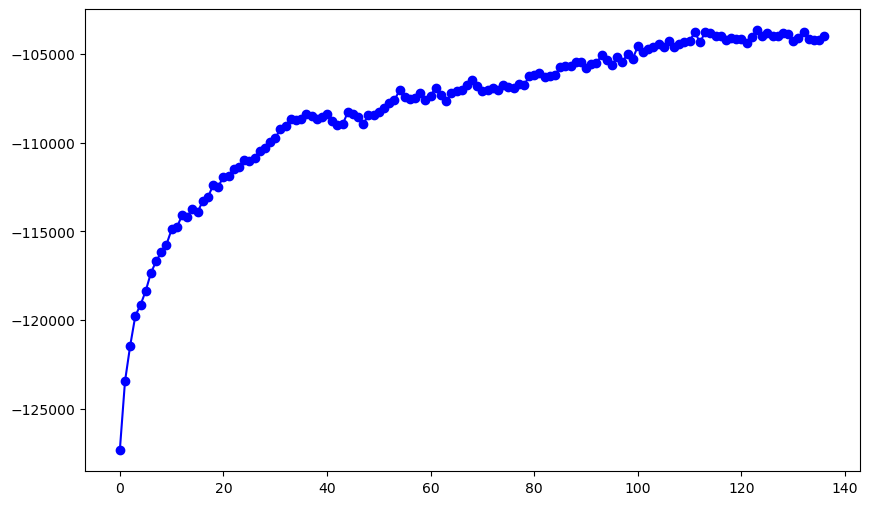

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(mycebmf.obj)[1:], marker='o', linestyle='-', color='b')

In [45]:
# Assuming 'Y' is the numpy array with your imputed data
# Also assuming 'original_values' is the original DataFrame before you removed 20% of the data
Y= mycebmf.Y_fit
# Extract the original values that were removed (same as before)
true_values = original_values.values[non_na_indices[remove_indices][:, 0], non_na_indices[remove_indices][:, 1]]

# Extract the corresponding imputed values from Y
imputed_values = Y[non_na_indices[remove_indices][:, 0], non_na_indices[remove_indices][:, 1]]

# Check if their shapes match
print(f"True values shape: {true_values.shape}")
print(f"Imputed values shape: {imputed_values.shape}")

# Calculate RMSE if shapes match
if true_values.shape == imputed_values.shape:
    rmse = np.sqrt(mean_squared_error(true_values, imputed_values))
    print(f'RMSE for your custom imputation method: {rmse}')
else:
    print("Error: Shape mismatch between true values and imputed values.")


True values shape: (20000,)
Imputed values shape: (20000,)
RMSE for your custom imputation method: 0.9537242384745925


In [52]:
Y=     np.sum( [np.outer(   mycebmf.L[:, k]  ,  mycebmf.F[:, k]    ) for k in range(5)], axis=0)
true_values = original_values.values[non_na_indices[remove_indices][:, 0], non_na_indices[remove_indices][:, 1]]

# Extract the corresponding imputed values from Y
imputed_values = Y[non_na_indices[remove_indices][:, 0], non_na_indices[remove_indices][:, 1]]

# Check if their shapes match
print(f"True values shape: {true_values.shape}")
print(f"Imputed values shape: {imputed_values.shape}")

# Calculate RMSE if shapes match
if true_values.shape == imputed_values.shape:
    rmse = np.sqrt(mean_squared_error(true_values, imputed_values))
    print(f'RMSE for your custom imputation method: {rmse}')
else:
    print("Error: Shape mismatch between true values and imputed values.")


True values shape: (20000,)
Imputed values shape: (20000,)
RMSE for your custom imputation method: 0.9656283731571004


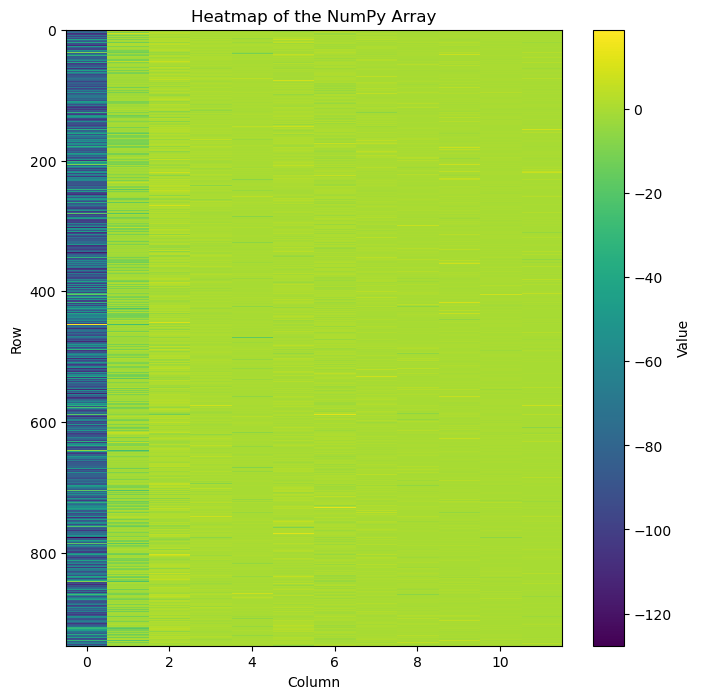

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming mycebmf.f is your NumPy array
plt.figure(figsize=(8, 8))  # You can adjust the size here
plt.imshow(mycebmf.L, cmap='viridis', aspect='auto', interpolation='nearest')  # 'aspect' set to auto for better scaling
plt.colorbar(label="Value")
plt.title("Heatmap of the NumPy Array")
plt.xlabel("Column")
plt.ylabel("Row")
plt.show()


In [55]:
k=1
mycebmf.cal_partial_residuals(k=k)
lhat , s_l  = compute_hat_l_and_s_l(Z = mycebmf.Rk,
                                                            nu = mycebmf.F[:,k] ,
                                                            omega= mycebmf.F2[:,k], 
                                                            tau= mycebmf.tau,
                                                            has_nan=mycebmf.has_nan)
 
betahat   =lhat
sebetahat =s_l 
prior     = mycebmf.prior_L
verbose=False
mult=np.sqrt(2) 



np.isinf (lhat ).any()
sebetahat 

array([0.38798392, 0.82196341, 0.842057  , 1.37234243, 0.5407377 ,
       0.47611688, 0.35572248, 0.79328911, 1.34108944, 0.53344372,
       0.48992284, 0.88981634, 0.26428385, 0.64191403, 0.60833727,
       0.58274199, 1.08643159, 0.4256313 , 1.40610429, 0.95374866,
       0.50447283, 0.58828687, 0.54620502, 0.77188407, 0.77294574,
       0.57803785, 1.07981434, 0.75954396, 1.02869748, 0.97177314,
       1.22215425, 1.0518715 , 1.10274353, 1.40557177, 1.15021594,
       1.4685482 , 0.7583584 , 0.60222671, 1.17949463, 0.9834196 ,
       0.99295997, 0.49589315, 0.44564211, 0.56635482, 0.93850382,
       1.18798589, 1.29248096, 0.88402189, 0.43769446, 1.24422603,
       1.37498384, 0.82183629, 1.14215135, 0.73183573, 1.29638665,
       0.50565025, 0.59834735, 0.51538063, 0.35731155, 0.50576082,
       1.31987577, 0.42565685, 0.62048076, 0.46508985, 0.76006009,
       0.87473575, 1.14483498, 0.99979352, 0.77084549, 0.58822275,
       1.00258149, 0.5548767 , 0.83228165, 1.03746745, 0.76250

In [56]:
betahat

array([-2.39755465e+00, -8.83787360e+00,  1.81334467e+00, -1.13548739e+01,
       -7.06542853e-01,  7.61263315e+00, -1.36209565e+00, -1.86265509e+00,
       -1.00338188e+01,  4.06349090e-01, -8.51326281e+00, -8.61694183e+00,
       -3.84607202e-01, -7.07214908e-01, -9.25160747e+00, -6.10841245e-01,
       -1.03988120e-01, -7.63445468e-01, -8.46703320e-01, -1.23428901e+01,
        1.74763487e+00,  1.55491473e+00,  6.96796294e-01,  1.87263554e-01,
       -8.88518312e+00, -8.67841284e+00, -1.24313850e+00, -8.59201949e+00,
       -4.72101584e-01, -2.30224589e+00,  4.88805114e-01, -1.02690275e+01,
       -9.95918354e+00, -1.14451547e+01, -1.22125774e+01, -1.48944710e+00,
       -1.98981892e+00, -8.64061839e+00, -1.33715193e+01, -1.13581274e+01,
       -4.83901106e-01, -1.76270135e+00, -1.26530226e+00, -2.51025939e+00,
       -7.44726385e+00, -1.04678039e+01, -1.02102138e+01, -1.48073987e+00,
        5.05369224e+00, -8.87649575e+00, -8.58871652e+00, -2.40409005e+00,
       -5.23764144e-01, -

In [ ]:
k=0
mycebmf.cal_partial_residuals(k=k)

fhat , s_f  = compute_hat_f_and_s_f(Z = mycebmf.Rk,
                                                            nu = mycebmf.L[:,k] ,
                                                            omega= mycebmf.L2[:,k], 
                                                            tau= mycebmf.tau,
                                                            has_nan=mycebmf.has_nan)
plt.scatter(np.log10(s_f), fhat)
betahat=fhat
sebetahat=s_f

In [17]:
scale=autoselect_scales_mix_exp(betahat  = betahat,
                                         sebetahat= sebetahat,
                                          mult=mult)
L= get_data_loglik_exp(betahat=betahat ,
                                 sebetahat=sebetahat , 
                                 scale=scale)
optimal_pi = optimize_pi_logL(  logL =L,
                                 penalty=10,
                                 verbose=verbose)  
log_pi=  np.tile(np.log(optimal_pi+1e-32), (betahat.shape[0],1))

In [ ]:
penalty=10

n, K = L.shape  # n: number of data points, K: number of components
pi =np.exp( - np.arange(0,K) )/ np.sum( np.exp( - np.arange(0,K) ))  # Initialize pi uniformly
vec_pen= np.ones_like(pi)
vec_pen[0]= penalty
pi

optimal_pi=pi

log_pi=  np.tile(np.log(optimal_pi+1e-32), (betahat.shape[0],1))
        
out= posterior_mean_exp(betahat, sebetahat,
                                 log_pi=log_pi, 
                                 scale=scale)

out.post_mean

In [19]:
assignment = np.exp(log_pi)
assignment = assignment / assignment.sum(axis=1, keepdims=True)
mu = 0
post_assign = np.zeros((betahat.shape[0], scale.shape[0]))
    
for i in range(betahat.shape[0]):
        post_assign[i,] = wpost_exp(x=betahat[i],
                                    s=sebetahat[i], 
                                    w=assignment[i,],
                                    scale=scale) 
    
post_mean = np.zeros(betahat.shape[0])
post_mean2 = np.zeros(betahat.shape[0])



In [ ]:


ash_obj = ash(betahat   =10*fhat,
                      sebetahat =s_f+1e-3 ,
                      prior     = "exp",
                      verbose=False
                      )
print(ash_obj.scale)

mycebmf.F  [:,k] =ash_obj.post_mean
mycebmf.F2 [:,k] =ash_obj.post_mean2
print(ash_obj.log_lik)

print(s_f)
 
plt.scatter(ash_obj.post_mean, fhat)

In [ ]:
ash_obj.pi

In [22]:
betahat   =fhat 
sebetahat =s_f  +1e-7
prior     = mycebmf.prior_F 

In [ ]:
scale=autoselect_scales_mix_exp(betahat  = betahat,
                                         sebetahat= sebetahat,
                                          mult=np.sqrt(2))

L= get_data_loglik_exp(betahat=betahat ,
                                 sebetahat=sebetahat , 
                                 scale=scale)
optimal_pi = optimize_pi( np.exp(L),
                                 penalty=10,
                                 verbose=True)  
log_pi=  np.tile(np.log(optimal_pi+1e-32), (betahat.shape[0],1))
        
out= posterior_mean_exp(betahat, sebetahat,
                                 log_pi=log_pi, 
                                 scale=scale)

In [ ]:
optimal_pi
plt.scatter(optimal_pi, range(optimal_pi.shape[0]))





In [ ]:
plt.scatter(fhat,out.post_mean )

In [ ]:
L

In [27]:
scale=autoselect_scales_mix_exp(betahat  = betahat,
                                         sebetahat= sebetahat,
                                          mult=np.sqrt(2))
L= get_data_loglik_exp(betahat=betahat ,
                                 sebetahat=sebetahat , 
                                 scale=scale)
optimal_pi = optimize_pi( np.exp(L),
                                 penalty=penalty,
                                 verbose=verbose)  
log_pi=  np.tile(np.log(optimal_pi+1e-32), (betahat.shape[0],1))
        
out= posterior_mean_exp(betahat, sebetahat,
                                 log_pi=log_pi, 
                                 scale=scale)

In [29]:
s_f=1e-8+s_f

In [ ]:
betahat   =lhat
sebetahat =s_l 
prior     = mycebmf.prior_L
verbose=False
mult=np.sqrt(2)

plt.scatter(betahat, sebetahat)

In [ ]:
np.sqrt(1e-32)
 
plt.scatter(betahat,np.log(sebetahat))
plt.axvline(x=0, color='red', linestyle='--')  # Add a horizontal line at y=0

In [ ]:
ash_obj.post_mean

In [ ]:
plt.scatter(s_f, fhat)

In [ ]:
res= ash(betahat=fhat, sebetahat=s_f, prior="exp")

In [ ]:
plt.hist(np.log10(s_f))